<a href="https://colab.research.google.com/github/supriyag123/PHD_Pub/blob/main/DGRNet%20STEP3-%20Hourly%20Data%20-%20MLP-%20Final%20-%20Window%20less%20than%2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

64/64 [==============================] - 0s 2ms/step
r2 score is == 0.417464320957319


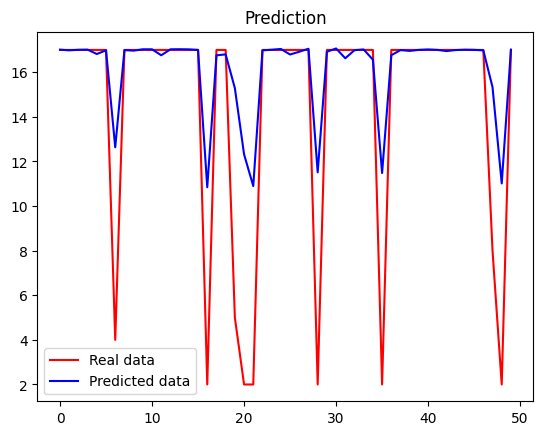

In [172]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import plotly.graph_objects as go
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed, Input
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import EarlyStopping
import keras.backend as K
from keras.callbacks import Callback
import plotly
import plotly.express as px # for data visualization
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import numpy as np
import scipy.stats as stats
import pylab as pl
#from keras import ops

generator_multiply = 4 #each input record will generate 100 random vectors from the latent space, given the mu and sigma generated by the encoder


train_data = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences-TRAIN_hourly.npy') #------for Hourly data
index = 500
#We missed i=500 from processing the iosw. So here we are dropping row with index =500
train_data= np.delete(train_data, index, axis=0)

window_label = np.load(r'/content/drive/MyDrive/PHD/2024/multivariate_long_sequences_WINDOW-TRAIN_hourly.npy')
n_seq = train_data.shape[0]
window_size = train_data.shape[1]
n_features = train_data.shape[2]


##---------------------------IGNORE THIS IF NOT GENERATING FRESH VAE DATASET--------------------------------------------------------------------------------------------
encoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-encoder-saved-hourly-latent10-dim128-latest.model')
decoder = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/VAE_SIMULATION/vae-decoder-saved-hourly-latent10-dim128-latest.model')

X_train_encoded = encoder.predict(train_data)
mu, logvar, z = X_train_encoded
sigma = tf.exp(0.5 * logvar)
batch = tf.shape(mu)[0]  #number of recors / batchs
dim = tf.shape(mu)[1] #Ndimension of latent variable
store = list()
storetemp = list()

#For each batch, iterate, get the generator_multipy number of latent vectors with same window_size.
#For each z, concatenate z_mean, so it will become 100 dimensional vector

for i in range(0,batch):
  all_Z_i = tf.random.normal(shape=(generator_multiply,dim), mean = mu[i,:], stddev=sigma[i,:]) #all randorm vectors for this record i
  X_train_decoded = decoder.predict(all_Z_i)
  X_train_decoded = X_train_decoded.reshape((X_train_decoded.shape[0],window_size*n_features))
  a = np.arange(generator_multiply)
  a.fill(window_label[i])
  c=np.concatenate(((X_train_decoded,a[:,None])),axis=1)
  store.append(c)

results1=np.concatenate(store,axis=0)
np.save(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_hourly_X4',results1)

#----------------------------------------------------------------------------------------------------------------------------------------------------------------------------

results1=np.load(r'/content/drive/MyDrive/PHD/2024/labelled_subsquence_data_hourly_X4.npy')

x=results1[:,:-1]
y=results1[:,window_size*n_features]

#maxval = x.shape[0]
#count_train = int(math.ceil(0.9*maxval))
#x_train = x[:count_train]
#x_test = x[count_train:]

#y_train = y[:count_train]
#y_test = y[count_train:]


from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.4)
yhat = iso.fit_predict(x)
# select all rows that are not outliers
mask = yhat != -1
x, y = x[mask, :], y[mask]



###############Scale the target and then split the data into train test----------------------------------------------------------------------------------------------------------------------------------
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.title("Distribution before Transformation", fontsize=15)
sns.histplot(y, kde=True, color="red")
plt.subplot(1,2,2)


#Looking at the dist, we remove al y less than 20
from sklearn.preprocessing import PowerTransformer
transformer = StandardScaler()

p = np.argwhere(y<20).flatten()
xf = np.take(x, p, 0)
yf= np.take(y, p, 0)
transformer = PowerTransformer()
y_transformed = transformer.fit_transform(yf.reshape(-1,1)).flatten()
x=xf



plt.title("Distribution after Transformation", fontsize=15)
sns.histplot(y_transformed,bins=10, kde=True , legend=False)
plt.xlabel("window")
plt.show()




x_train, x_test, y_train, y_test = train_test_split(xf, y_transformed, test_size = 0.05, random_state = 42)

#--------------------------------------------------------------------------------------CONSTRUCT, COMPILE, AND TRAIN THE MODEL------------------------------------------------------------------------------------------------------------------
#------------MLP------------------------------------------------------
#x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
#x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
from keras.layers import LeakyReLU

model = Sequential()
#model.add(LSTM(1024, input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True))
#model.add(Dropout(0.2))
#model.add(LSTM(512,return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(units = 1024))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 512))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 256))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 128))
#model.add(LeakyReLU(alpha=0.01))

model.add(Dense(units = 32))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.1))
model.add(Dense(units = 8))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(units = 1))
#--------------------------------------------------------------LSTM--------------------------

a =  x_train.reshape((x_train.shape[0], window_size, n_features))  #DONT RUN IF MLP
b =  x_test.reshape((x_test.shape[0], window_size, n_features))    #DONT RUN IF MLP

from keras.layers import LeakyReLU
model = Sequential()
model.add(LSTM(32, input_shape=(a.shape[1],a.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dropout(0.2))
#model.add(Dense(units = 1024))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 512))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 512))
#model.add(LeakyReLU(alpha=0.1))
#model.add(Dense(units = 256))
#model.add(LeakyReLU(alpha=0.1))

model.add(Dense(units = 16))
model.add(LeakyReLU(alpha=0.3))
#model.add(Dense(units = 16))
#model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units = 8))
model.add(LeakyReLU(alpha=0.3))
#model.add(Dense(units = 4))
#model.add(LeakyReLU(alpha=0.01))
model.add(Dense(units = 1, activation = 'linear'))
model.summary()
x_train = a
x_test = b
#-------------------------------------------------------------------------------------


#sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
optimizr = keras.optimizers.Adam(learning_rate=0.001,clipnorm=1)
model.compile(loss='mean_squared_error', optimizer= optimizr, metrics=['mean_squared_error'])

es = keras.callbacks.EarlyStopping(patience=20, verbose=1, min_delta=0.0001, monitor='loss', mode='min', restore_best_weights=True)
n_epochs = 500

history=model.fit( x_train,y_train,
                 epochs=n_epochs,
                 batch_size=32,
                   validation_split=0.3,
                 callbacks=[es])

#-----------------------------------------------------TRAIN EVALUATION----------------------------------------------------------------
y_train_pred_raw = model.predict(x_train)
y_train_pred = transformer.inverse_transform(y_train_pred_raw)
y_train_true = transformer.inverse_transform(y_train.reshape(-1,1)).flatten()

score_train= r2_score(y_train_true,y_train_pred)
print("r2 score is ==",score_train)

plt.plot(y_train_true[0:100], color = 'red', label = 'Real data')
plt.plot(y_train_pred[0:100], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()


#-----------------------------------------------------TEST EVALUATION----------------------------------------------------------------

y_pred_raw = model.predict(x_test)
y_test_pred = transformer.inverse_transform(y_pred_raw)
y_test_true = transformer.inverse_transform(y_test.reshape(-1,1)).flatten()



score= r2_score(y_test_true,y_test_pred)
print("r2 score is ==",score)


plt.plot(y_test_true[100:150], color = 'red', label = 'Real data')
plt.plot(y_test_pred[100:150], color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

#------------------------------------------------------SAVE MODEL AND RESULTS-----------------------------------------------------------------

model.save(r'/content/drive/MyDrive/PHD/2024/DGRNet-MLP-Versions/MLP_model_hourly.keras')
# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model(r'/content/drive/MyDrive/PHD/2024/DGRNet-MLP-Versions/MLP_model_hourly.keras')

# Let's check:
np.testing.assert_allclose(
    model.predict(test_input), reconstructed_model.predict(test_input)
)


np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/preduber_2.csv',y_pred)
np.savetxt(r'/content/drive/MyDrive/PHD/2024/MLPOutput/realuber_2.csv',y_test)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')